In [32]:
import torch
from pathlib import Path
from pydicom import dcmread
from PIL import Image
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Get all the train data samples and test data samples path as list

data_file = Path('data/pneumonia_dataset')

train_path = list(data_file.glob('stage_2_train_images/*.dcm'))
test_path = list(data_file.glob('stage_2_test_images/*.dcm'))
print(f'Train Data Images: {len(train_path)}')
print(f'Test Data Images: {len(test_path)}')

Train Data Images: 26684
Test Data Images: 3000


In [9]:
# Split the total data of 26684 into train and val dataset for YOLOv8
train_size = 20000


yolo_train_path = train_path[0: 20000]
val_path = train_path[20000:]

print(f'YOLO Train Data Samples: {len(yolo_train_path)}')
print(f'YOLO val Data Samples: {len(val_path)}')

YOLO Train Data Samples: 20000
YOLO val Data Samples: 6684


In [18]:
# File path of the labels from the working data and convert the csv file into a pandas DataFrame

label_file_path = 'data/pneumonia_dataset/stage_2_train_labels.csv'
label_csv = pd.read_csv(label_file_path)
label_csv

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


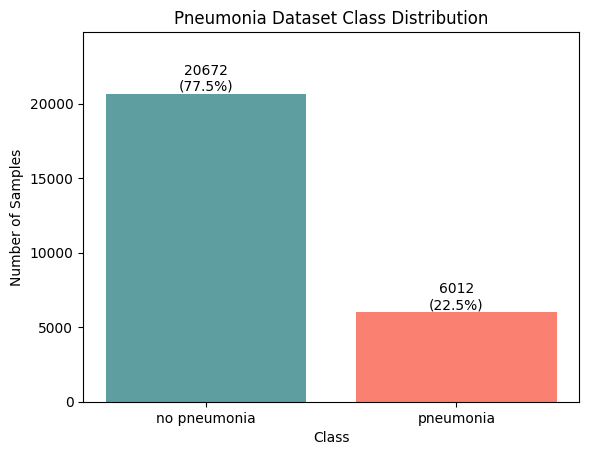

In [135]:
# Number of Data samples with pneumonia and without pneumonia

counts = label_csv.drop_duplicates('patientId')['Target'].value_counts()

# num_no_pneumonia = counts[0]
# num_pneumonia = counts[1]

data_class = {
    'no pneumonia': int(counts.get(0, 0)),
    'pneumonia': int(counts.get(1, 0))
}

total = sum(data_class.values())


bars = plt.bar(data_class.keys(), data_class.values(), color=['cadetblue', 'salmon'])
plt.bar_label(bars, labels=[f"{value}\n({value/total*100:.1f}%)" for value in data_class.values()])
plt.ylim(0, 1.2*max(data_class.values()))
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Pneumonia Dataset Class Distribution')
plt.show()


In [141]:
# Check if neumonia cases vary by metadata like (age, sex, image view)

data = dcmread(train_path[0])
data

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 202
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002,0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008,0020) Study Date                          DA: '19010101'
(0008,0030) Study Time                  

In [10]:
def dcm_to_jpg(dcm_path, save_path):
    '''
    Convert a DICOM (.dcm) file to a JPEG (.jpg) file and save it.

    This function reads a DICOM file from `dcm_path`, converts the pixel data
    to an image, and saves the image as a JPEG file at `save_path`.

    Args:
        dcm_path (str): File path of the input DICOM file.
        save_path (str): File path to save the output JPEG file.

    Returns:
        None
    '''
    save_path = Path(save_path)

    if not save_path.is_dir():
        dcm_data = dcmread(dcm_path)
        dcm_pixel_array = dcm_data.pixel_array
        image = Image.fromarray(dcm_pixel_array)
        image.save(save_path, 'JPEG')


In [11]:
# Create YOLO File format list

yolo_file_format = ['YOLO_format_data', ['images', 'labels', 'data.yaml'], ['train', 'val']]

# Create the YOLO file format directory
for x in range(2):
    for y in range(2):
        form_path = os.path.join(yolo_file_format[0], yolo_file_format[1][x], yolo_file_format[2][y])
        form_path = Path(form_path)
        form_path.mkdir(parents=True, exist_ok=True)

# # Create data.yaml file
yaml_file = Path(yolo_file_format[0]) / yolo_file_format[1][2]

# Content for the data.yaml file as required by the YOLO model
yaml_content = {
    'train': f'{yolo_file_format[1][0]}/{yolo_file_format[2][0]}',
    'val': f'{yolo_file_format[1][0]}/{yolo_file_format[2][1]}',
    'nc': 1,
    'names': ['pneumonia']
}

# write the content into the data.yaml file
with open(yaml_file, 'w') as file:
    yaml.dump(yaml_content, file)

In [12]:
# Save all the training images into the images direcotry

train_image_name_list = []
for x in range(len(yolo_train_path)):
    img = f'img{x+1}.jpg'
    train_image_name_list.append(img)

train_yolo_img = Path('YOLO_format_data/images/train')



for index, path in enumerate(yolo_train_path):
    save_path = os.path.join(train_yolo_img, train_image_name_list[index])
    dcm_to_jpg(dcm_path=path, save_path=save_path)



In [13]:
# Save all the val images into the val directory

val_image_name_list = []
cont = len(train_image_name_list)
cont
for x in range(len(val_path)):
    img = f'img{cont+x+1}.jpg'
    val_image_name_list.append(img)

val_yolo_img = Path('YOLO_format_data/images/val')

for index, path in enumerate(val_path):
    save_path = os.path.join(val_yolo_img, val_image_name_list[index])
    dcm_to_jpg(dcm_path=path, save_path=save_path)

In [14]:
# File path of the labels from the working data and convert the csv file into a pandas DataFrame

label_file_path = 'data/pneumonia_dataset/stage_2_train_labels.csv'
label_csv = pd.read_csv(label_file_path)
label_csv

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [15]:
# Create a list of all the txt files names for train labels file

train_image_txt_list = []

for image_name in train_image_name_list:
    image_name = Path(image_name)
    name = image_name.stem
    txt_fil_name = f'{name}.txt'
    train_image_txt_list.append(txt_fil_name)

In [16]:
# File path to save the train labels file to
labels_train = Path('YOLO_format_data/labels/train')


# Iterate over each path from the list of training data path
for index, path in enumerate(yolo_train_path):

    # Patient Id of the instance of data 
    id = path.stem
    # Get all the label data associated with the Id
    bbox_data = label_csv[label_csv['patientId'] == id] 

    # final file path to save the instance of label data to
    labels_train_txt = os.path.join(labels_train, train_image_txt_list[index])

    # Create a  label file for each image data
    with open(labels_train_txt, 'w') as f:
        # write label into the file if the bbox for the image exists 
        if bbox_data.iloc[0, 5].item() == 1:
            label_class_id = bbox_data.iloc[0, 5].item()
            for x in range(len(bbox_data)):
                x1 = bbox_data.iloc[x, 1].item() / 1024
                y1 = bbox_data.iloc[x, 2].item() / 1024
                width = bbox_data.iloc[x, 3].item() / 1024
                height = bbox_data.iloc[x, 4].item() / 1024
                f.write(f'{label_class_id-1} {x1} {y1} {width} {height}')
                f.write('\n')
        # Write nth into the file if no bbox for the instance of data exist
        else:
            pass

In [17]:
# Create a list of all the txt files names for val labels file

val_image_txt_list = []

for image_name in val_image_name_list:
    image_name = Path(image_name)
    name = image_name.stem
    txt_fil_name = f'{name}.txt'
    val_image_txt_list.append(txt_fil_name)

In [18]:
labels_val = Path('YOLO_format_data/labels/val')

x = 0
for index, path in enumerate(val_path):
    id = path.stem
    bbox_data = label_csv[label_csv['patientId'] == id]

    labels_train_txt = os.path.join(labels_val, val_image_txt_list[index])

    with open(labels_train_txt, 'w') as f:
        if bbox_data.iloc[0, 5].item() == 1:
            label_class_id = bbox_data.iloc[0, 5].item()
            for x in range(len(bbox_data)):
                x1 = bbox_data.iloc[x, 1].item() / 1024
                y1 = bbox_data.iloc[x, 2].item() / 1024
                width = bbox_data.iloc[x, 3].item() / 1024
                height = bbox_data.iloc[x, 4].item() / 1024
                f.write(f'{label_class_id-1} {x1} {y1} {width} {height}')
                f.write('\n')
        # Write nth into the file if no bbox for the instance of data exist
        else:
            pass

    # break
    

# Workign with the data part is done...now fine tuning the model part


In [19]:
from ultralytics import YOLO

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
model = YOLO('yolov8n.pt')

In [22]:
train_results = model.train(
    data='YOLO_format_data/data.yaml',
    epochs=5,
    imgsz=640,
    batch=16,
    name='medical_imaging'
)

New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.145  Python-3.13.1 torch-2.6.0+cu126 CUDA:0 (NVIDIA T400 4GB, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_format_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=medical_imaging, nbs=64, nms=False, opset=None, opt

train: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\train... 20000 images, 14917 backgrounds, 0 corrupt: 100%|██████████| 20000/20000 [00:18<00:00, 1102.88it/s]


train: New cache created: C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\train.cache
val: Fast image access  (ping: 0.10.1 ms, read: 4.40.9 MB/s, size: 57.1 KB)


val: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\val... 6684 images, 5755 backgrounds, 0 corrupt: 100%|██████████| 6684/6684 [00:05<00:00, 1143.52it/s]


val: New cache created: C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\val.cache
Plotting labels to c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\runs\detect\medical_imaging\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\runs\detect\medical_imaging
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      3.82G      2.372      4.695      2.326         14        640: 100%|██████████| 1250/1250 [21:50<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:59<00:00,  1.17it/s]


                   all       6684       1359      0.007       0.71     0.0475     0.0153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.84G      2.185      3.388       2.17         11        640: 100%|██████████| 1250/1250 [22:09<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:09<00:00,  1.10it/s]


                   all       6684       1359     0.0674      0.231     0.0525     0.0172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.84G        2.1      3.194        2.1         14        640:  78%|███████▊  | 973/1250 [16:28<04:41,  1.02s/it]


KeyboardInterrupt: 

In [ ]:
# len(yolo_train_path)
# x = dcmread(yolo_train_path[3])
# shape = x.pixel_array.shape
# for x in shape:
#     print(x)


# for index, path in enumerate(yolo_train_path):
#     data = dcmread(path)
#     image_shape = data.pixel_array.shape
#     for x in image_shape:
#         if x != 1024:
#             print(index)
#             break

1024
1024


In [ ]:
# Continue training the mdoel form where it left of last time

from ultralytics import YOLO

model = YOLO('runs/detect/medical_imaging_v22/weights/last.pt')

In [2]:
model.train(resume=True)

New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.145  Python-3.13.1 torch-2.6.0+cu126 CUDA:0 (NVIDIA T400 4GB, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_format_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs\detect\medical_imaging_v22\weights\last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=medical_imagin

train: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\train.cache... 20000 images, 14917 backgrounds, 0 corrupt: 100%|██████████| 20000/20000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 212.5133.7 MB/s, size: 57.1 KB)


val: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\val.cache... 6684 images, 5755 backgrounds, 0 corrupt: 100%|██████████| 6684/6684 [00:00<?, ?it/s]


Plotting labels to runs\detect\medical_imaging_v22\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training runs\detect\medical_imaging_v22\weights\last.pt from epoch 2 to 5 total epochs
Closing dataloader mosaic
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\medical_imaging_v22
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.85G      1.941       2.92      1.999         14        640: 100%|██████████| 1250/1250 [21:24<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:00<00:00,  1.16it/s]


                   all       6684       1359      0.161      0.194      0.101     0.0321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.84G      1.961      2.937      2.002         11        640: 100%|██████████| 1250/1250 [21:56<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:07<00:00,  1.11it/s]

                   all       6684       1359      0.236      0.162      0.122     0.0422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.83G      1.931      2.872      1.981         28        640: 100%|██████████| 1250/1250 [21:24<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:08<00:00,  1.11it/s]


                   all       6684       1359      0.173      0.283      0.114     0.0394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.878      2.784      1.939          8        640: 100%|██████████| 1250/1250 [21:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:10<00:00,  1.10it/s]

                   all       6684       1359      0.295      0.241      0.206     0.0731



4 epochs completed in 1.640 hours.
Optimizer stripped from runs\detect\medical_imaging_v22\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\medical_imaging_v22\weights\best.pt, 6.2MB

Validating runs\detect\medical_imaging_v22\weights\best.pt...
Ultralytics 8.3.145  Python-3.13.1 torch-2.6.0+cu126 CUDA:0 (NVIDIA T400 4GB, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [01:46<00:00,  1.96it/s]


                   all       6684       1359      0.296      0.241      0.206      0.073
Speed: 0.5ms preprocess, 14.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\medical_imaging_v22


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E0815BE060>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [3]:

model = YOLO('runs/detect/medical_imaging_v3/weights/last.pt')

model.train(data='YOLO_format_data/data.yaml', epochs=20, project='runs/detect', name='medical_imaging_v4')


New https://pypi.org/project/ultralytics/8.3.148 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.145  Python-3.13.1 torch-2.6.0+cu126 CUDA:0 (NVIDIA T400 4GB, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_format_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/medical_imaging_v3/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=medical_imagin

train: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\train.cache... 20000 images, 14917 backgrounds, 0 corrupt: 100%|██████████| 20000/20000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 255.392.2 MB/s, size: 57.1 KB)


val: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\val.cache... 6684 images, 5755 backgrounds, 0 corrupt: 100%|██████████| 6684/6684 [00:00<?, ?it/s]


Plotting labels to runs\detect\medical_imaging_v4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\medical_imaging_v4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.84G      1.617      2.368      1.744         14        640: 100%|██████████| 1250/1250 [21:58<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:08<00:00,  1.11it/s]

                   all       6684       1359      0.274       0.26      0.205     0.0737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.83G      1.738      2.511      1.819         11        640: 100%|██████████| 1250/1250 [21:01<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:19<00:00,  1.05it/s]

                   all       6684       1359      0.295      0.247      0.179     0.0654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.83G      1.794      2.626      1.863         28        640: 100%|██████████| 1250/1250 [20:22<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:27<00:00,  1.42it/s]

                   all       6684       1359      0.246      0.229       0.16      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.84G      1.823      2.632      1.877          8        640: 100%|██████████| 1250/1250 [20:29<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:43<00:00,  1.28it/s]

                   all       6684       1359      0.229      0.208       0.14     0.0526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.83G      1.822      2.628      1.874          4        640: 100%|██████████| 1250/1250 [21:31<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:03<00:00,  1.14it/s]

                   all       6684       1359       0.28      0.281      0.193     0.0686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.83G      1.854      2.675      1.906          8        640: 100%|██████████| 1250/1250 [21:13<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:58<00:00,  1.17it/s]


                   all       6684       1359      0.279      0.266      0.193     0.0683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.84G      1.842      2.673       1.89         14        640: 100%|██████████| 1250/1250 [21:01<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:56<00:00,  1.19it/s]

                   all       6684       1359      0.299      0.244      0.192     0.0699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.83G      1.857      2.721      1.895         15        640:   6%|▌         | 74/1250 [01:16<20:10,  1.03s/it]


KeyboardInterrupt: 

In [1]:
from ultralytics import YOLO

model = YOLO('runs/detect/medical_imaging_v4/weights/last.pt')

In [2]:
model.train(resume=True)

New https://pypi.org/project/ultralytics/8.3.149 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.145  Python-3.13.1 torch-2.6.0+cu126 CUDA:0 (NVIDIA T400 4GB, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_format_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs\detect\medical_imaging_v4\weights\last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=medical_imagin

train: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\train.cache... 20000 images, 14917 backgrounds, 0 corrupt: 100%|██████████| 20000/20000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 191.471.5 MB/s, size: 57.1 KB)


val: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\val.cache... 6684 images, 5755 backgrounds, 0 corrupt: 100%|██████████| 6684/6684 [00:00<?, ?it/s]


Plotting labels to runs\detect\medical_imaging_v4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training runs\detect\medical_imaging_v4\weights\last.pt from epoch 8 to 20 total epochs
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\medical_imaging_v4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.85G       1.77      2.584      1.846         14        640: 100%|██████████| 1250/1250 [21:35<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:58<00:00,  1.17it/s]

                   all       6684       1359      0.277      0.248      0.188     0.0648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.83G      1.752      2.534      1.832         11        640: 100%|██████████| 1250/1250 [21:36<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:07<00:00,  1.12it/s]

                   all       6684       1359      0.294       0.29      0.202     0.0765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.83G      1.742      2.528      1.821         28        640: 100%|██████████| 1250/1250 [20:07<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:03<00:00,  1.14it/s]

                   all       6684       1359      0.326      0.277      0.236     0.0846


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.83G      1.768      2.484      1.852          6        640: 100%|██████████| 1250/1250 [20:06<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:06<00:00,  1.12it/s]

                   all       6684       1359       0.28      0.246      0.193      0.072



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.83G      1.738      2.506       1.81          1        640: 100%|██████████| 1250/1250 [20:17<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:55<00:00,  1.19it/s]

                   all       6684       1359      0.311      0.274      0.245     0.0873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.83G      1.727      2.426      1.818          6        640: 100%|██████████| 1250/1250 [19:40<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:01<00:00,  1.15it/s]

                   all       6684       1359      0.315      0.266      0.229     0.0829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.83G      1.717       2.39      1.802          4        640: 100%|██████████| 1250/1250 [21:15<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:56<00:00,  1.18it/s]

                   all       6684       1359      0.274      0.306      0.222     0.0826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.83G      1.694      2.394      1.774          2        640: 100%|██████████| 1250/1250 [20:49<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:06<00:00,  1.12it/s]

                   all       6684       1359      0.311      0.277      0.237     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.83G      1.668      2.374      1.766          8        640: 100%|██████████| 1250/1250 [19:17<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:10<00:00,  1.60it/s]

                   all       6684       1359      0.319      0.321      0.249     0.0902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.83G      1.677      2.326      1.767          8        640: 100%|██████████| 1250/1250 [20:19<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:43<00:00,  1.28it/s]

                   all       6684       1359      0.315      0.302      0.242     0.0861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.83G      1.666      2.307      1.765         10        640: 100%|██████████| 1250/1250 [20:30<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:44<00:00,  1.27it/s]

                   all       6684       1359      0.313      0.294      0.244     0.0856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.83G      1.659      2.263      1.768          7        640: 100%|██████████| 1250/1250 [20:13<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:59<00:00,  1.16it/s]

                   all       6684       1359      0.326        0.3      0.253     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.83G      1.631      2.263      1.744          7        640: 100%|██████████| 1250/1250 [20:43<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:54<00:00,  1.20it/s]

                   all       6684       1359      0.331      0.299      0.258     0.0918



13 epochs completed in 5.083 hours.
Optimizer stripped from runs\detect\medical_imaging_v4\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\medical_imaging_v4\weights\best.pt, 6.2MB

Validating runs\detect\medical_imaging_v4\weights\best.pt...
Ultralytics 8.3.145  Python-3.13.1 torch-2.6.0+cu126 CUDA:0 (NVIDIA T400 4GB, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [01:46<00:00,  1.97it/s]


                   all       6684       1359      0.327        0.3      0.258     0.0918
Speed: 0.5ms preprocess, 14.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\medical_imaging_v4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000028704BB25F0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480